# Credit Risk with PCA and without PCA

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Load dataset
df = pd.read_csv("train_mini.csv")

# Preview dataset
df.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5037048,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,With parents,-16271,-3111,1,0,0,0,Core staff,2.0,-17.0,0
1,5044630,F,Y,N,1,135000.0,Commercial associate,Higher education,Single / not married,House / apartment,-10130,-1651,1,0,0,0,Accountants,2.0,-1.0,0
2,5079079,F,N,Y,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12821,-5657,1,0,0,0,Laborers,4.0,-38.0,0
3,5112872,F,Y,Y,0,360000.0,Commercial associate,Higher education,Single / not married,House / apartment,-20929,-2046,1,0,0,1,Managers,1.0,-11.0,0
4,5105858,F,N,N,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,-16207,-515,1,0,1,0,NaN,1.0,-41.0,0


In [6]:
categorical_cols = ['Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')  # Fill missing values
    df[col] = le.fit_transform(df[col])

# Fill missing numeric columns
numeric_cols = ['Age', 'Employment length', 'Family member count', 'Account age']
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Convert boolean-like columns to integers
boolean_cols = ['Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email']
for col in boolean_cols:
    df[col] = df[col].astype(int)

In [7]:
# Binary columns to encode
binary_cols = ['Gender', 'Has a car', 'Has a property']

# Map binary values to 0 and 1
binary_mapping = {
    'Gender': {'M': 1, 'F': 0},
    'Has a car': {'Y': 1, 'N': 0},
    'Has a property': {'Y': 1, 'N': 0}
}

# Apply the mapping
for col, mapping in binary_mapping.items():
    df[col] = df[col].map(mapping)

# Verify the encoding
print(df[binary_cols].head())


   Gender  Has a car  Has a property
0       1          1               1
1       0          1               0
2       0          0               1
3       0          1               1
4       0          0               0


In [8]:
# Define X and y
X = df.drop('Is high risk', axis=1)
y = df['Is high risk']

# Normalize numeric features
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Step 1: Handle Imbalanced Data with SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X, y)


<IPython.core.display.Javascript object>

Model Accuracy: 98.53%


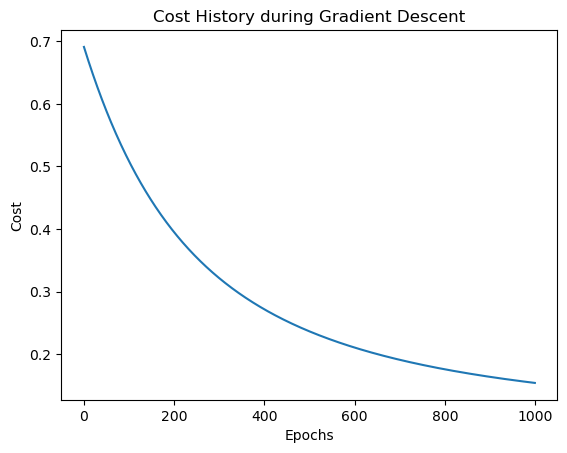

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retaining 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Step 4: Add intercept term (bias term) to the feature set
X_with_intercept = np.hstack((np.ones((X_pca.shape[0], 1)), X_pca))

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_intercept, y, test_size=0.2, random_state=42)

# Step 6: Initialize weights (weights should have one more value to accommodate the intercept)
weights = np.zeros(X_train.shape[1])

# Step 7: Set learning rate and epochs
learning_rate = 0.01
epochs = 1000

# Step 8: Perform Gradient Descent
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, weights):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

def gradient_descent(X, y, weights, learning_rate, epochs):
    m = len(y)
    cost_history = []
    
    for _ in range(epochs):
        h = sigmoid(np.dot(X, weights))  # Predicted probabilities
        gradient = np.dot(X.T, (h - y)) / m  # Compute the gradient
        weights -= learning_rate * gradient  # Update weights
        cost = compute_cost(X, y, weights)  # Compute the cost (loss)
        cost_history.append(cost)  # Store cost for analysis
        
    return weights, cost_history

# Perform gradient descent to optimize the weights
weights, cost_history = gradient_descent(X_train, y_train, weights, learning_rate, epochs)

# Step 9: Evaluate the model on the test set
def predict(X, weights):
    return sigmoid(np.dot(X, weights)) >= 0.5  # Threshold at 0.5 for classification

# Predict on the test set
y_pred = predict(X_test, weights)

# Step 10: Evaluate the model performance (you can use accuracy or any other metrics)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Optionally, you can also print the cost history to visualize the convergence
import matplotlib.pyplot as plt
plt.plot(range(epochs), cost_history)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost History during Gradient Descent')
plt.show()

# Minibatch Gradient Descendent

Epoch 0, Cost: 0.18645964374812202
Epoch 100, Cost: 0.08591007329749656
Epoch 200, Cost: 0.0859099345692555
Epoch 300, Cost: 0.08590990542663432
Epoch 400, Cost: 0.08591013442946929
Epoch 500, Cost: 0.0859098567545479
Epoch 600, Cost: 0.08590985968348845
Epoch 700, Cost: 0.08590989712300216
Epoch 800, Cost: 0.08590987515882152
Epoch 900, Cost: 0.08590988329030863
Model Accuracy: 98.53%


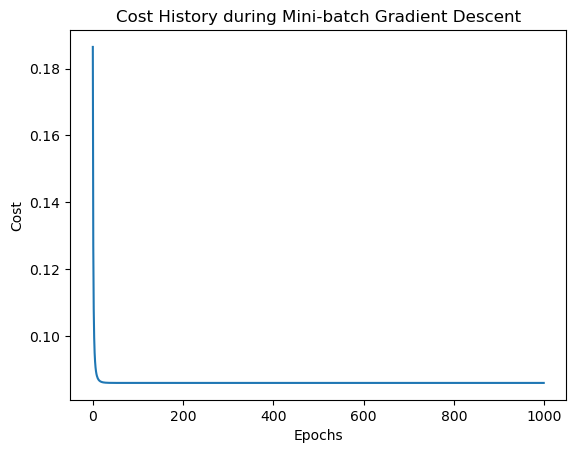

In [10]:


import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing (Scale the features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is your feature set

# Step 2: Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retaining 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Step 3: Add intercept term (bias term) to the feature set
X_with_intercept = np.hstack((np.ones((X_pca.shape[0], 1)), X_pca))

# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_intercept, y, test_size=0.2, random_state=42)

# Step 5: Initialize weights (weights should have one more value to accommodate the intercept)
weights = np.zeros(X_train.shape[1])

# Step 6: Set learning rate, batch size, and epochs
learning_rate = 0.01
batch_size = 32  # Mini-batch size
epochs = 1000

# Sigmoid and cost functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, weights):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

# Mini-batch gradient descent function
def mini_batch_sgd(X, y, weights, learning_rate, batch_size, epochs):
    m = len(y)
    cost_history = []

    for epoch in range(epochs):
        # Shuffle the data at the start of each epoch
        permutation = np.random.permutation(m)
        X_shuffled = X[permutation]
        y_shuffled = y.iloc[permutation].values


        # Process mini-batches
        for i in range(0, m, batch_size):
            # Create mini-batch
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Compute predictions
            h = sigmoid(np.dot(X_batch, weights))

            # Compute gradients
            gradient = np.dot(X_batch.T, (h - y_batch)) / batch_size

            # Update weights
            weights -= learning_rate * gradient

        # Calculate and record cost after each epoch
        cost = compute_cost(X, y, weights)
        cost_history.append(cost)

        # Optionally, print cost at each epoch
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Cost: {cost}")

    return weights, cost_history

# Perform mini-batch gradient descent to optimize the weights
weights, cost_history = mini_batch_sgd(X_train, y_train, weights, learning_rate, batch_size, epochs)

# Step 7: Evaluate the model on the test set
def predict(X, weights):
    return sigmoid(np.dot(X, weights)) >= 0.5  # Threshold at 0.5 for classification

# Predict on the test set
y_pred = predict(X_test, weights)

# Step 8: Evaluate the model performance (you can use accuracy or any other metrics)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Optionally, plot the cost history to visualize the convergence
plt.plot(range(epochs), cost_history)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost History during Mini-batch Gradient Descent')
plt.show()



In [ ]:
Strochastic 

Epoch 0, Cost: 0.08612200005743145
Epoch 100, Cost: 0.08628354036517828
Epoch 200, Cost: 0.08621715762209302
Epoch 300, Cost: 0.08704421917175868
Epoch 400, Cost: 0.08620570425181633
Epoch 500, Cost: 0.08644428040356399
Epoch 600, Cost: 0.08623659337800665
Epoch 700, Cost: 0.08672605986360622
Epoch 800, Cost: 0.08631051752699646
Epoch 900, Cost: 0.08714417909018433
Model Accuracy: 98.53%


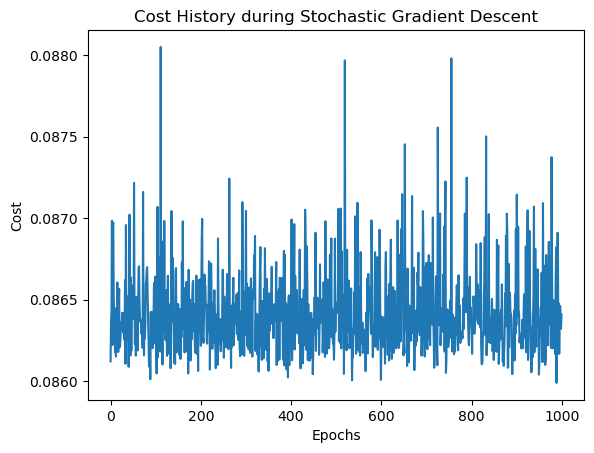

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing (Scale the features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is your feature set

# Step 2: Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retaining 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Step 3: Add intercept term (bias term) to the feature set
X_with_intercept = np.hstack((np.ones((X_pca.shape[0], 1)), X_pca))

# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_intercept, y, test_size=0.2, random_state=42)

# Step 5: Initialize weights (weights should have one more value to accommodate the intercept)
weights = np.zeros(X_train.shape[1])

# Step 6: Set learning rate and epochs
learning_rate = 0.01
epochs = 1000

# Sigmoid and cost functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, weights):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

# Stochastic Gradient Descent function
def stochastic_gradient_descent(X, y, weights, learning_rate, epochs):
    m = len(y)
    cost_history = []

    for epoch in range(epochs):
        # Shuffle the data at the start of each epoch
        permutation = np.random.permutation(m)
        X_shuffled = X[permutation]
        y_shuffled = y.iloc[permutation].values

        for i in range(m):
            # Use a single data point (stochastic update)
            X_sample = X_shuffled[i:i + 1]
            y_sample = y_shuffled[i:i + 1]

            # Compute prediction
            h = sigmoid(np.dot(X_sample, weights))

            # Compute gradient
            gradient = np.dot(X_sample.T, (h - y_sample))

            # Update weights
            weights -= learning_rate * gradient

        # Calculate and record cost after each epoch
        cost = compute_cost(X, y, weights)
        cost_history.append(cost)

        # Optionally, print cost at each epoch
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Cost: {cost}")

    return weights, cost_history

# Perform stochastic gradient descent to optimize the weights
weights, cost_history = stochastic_gradient_descent(X_train, y_train, weights, learning_rate, epochs)

# Step 7: Evaluate the model on the test set
def predict(X, weights):
    return sigmoid(np.dot(X, weights)) >= 0.5  # Threshold at 0.5 for classification

# Predict on the test set
y_pred = predict(X_test, weights)

# Step 8: Evaluate the model performance (you can use accuracy or any other metrics)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Optionally, plot the cost history to visualize the convergence
plt.plot(range(epochs), cost_history)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost History during Stochastic Gradient Descent')
plt.show()


In [7]:
import numpy as np

# Function to predict whether the person is at risk (1) or not at risk (0)
def predict_risk(input_data, weights, scaler, pca):
    # Ensure input_data has the same number of features as expected by the model (19 features)
    if input_data.shape[0] != 19:
        raise ValueError("Input data must have 19 features")

    # Step 1: Standardize the input data (reshape it to 2D)
    input_data_scaled = scaler.transform(input_data.reshape(1, -1))  # Use the same scaler used during training

    # Step 2: Apply PCA to the input data
    input_data_pca = pca.transform(input_data_scaled)  # Use the same PCA used during training

    # Step 3: Add intercept term (bias term)
    input_data_with_intercept = np.hstack((np.ones((input_data_pca.shape[0], 1)), input_data_pca))

    # Step 4: Compute prediction using logistic regression
    probability = sigmoid(np.dot(input_data_with_intercept, weights))  # Get the probability

    # Step 5: Return the risk classification (0 or 1)
    return 1 if probability >= 0.5 else 0

# Example input: assuming your input features are similar to the ones you used in the training set
input_data = np.array([5037048, 1, 1, 1, 0, 135000.0, 4, 4, 1, 5, -16271, -3111, 1, 0, 0, 0, 3, 2.0, -17.0])  # Example of 19 features (fixing the number of features)

# Make prediction
risk_prediction = predict_risk(input_data, weights, scaler, pca)

if risk_prediction == 1:
    print("Risk: Yes")
else:
    print("Risk: No")


Risk: No


C:\Users\bharu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
